In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.signal import find_peaks as fp
from sklearn import preprocessing

In [67]:
'''
RAW DATA EXCTRACTION.
'''
# Path Search and Data Extraction
path = 'example.txt'
filename = path[:-4]
df_raw = pd.read_csv(path, sep='\t', names=['shift','intensity'], index_col = 'shift')

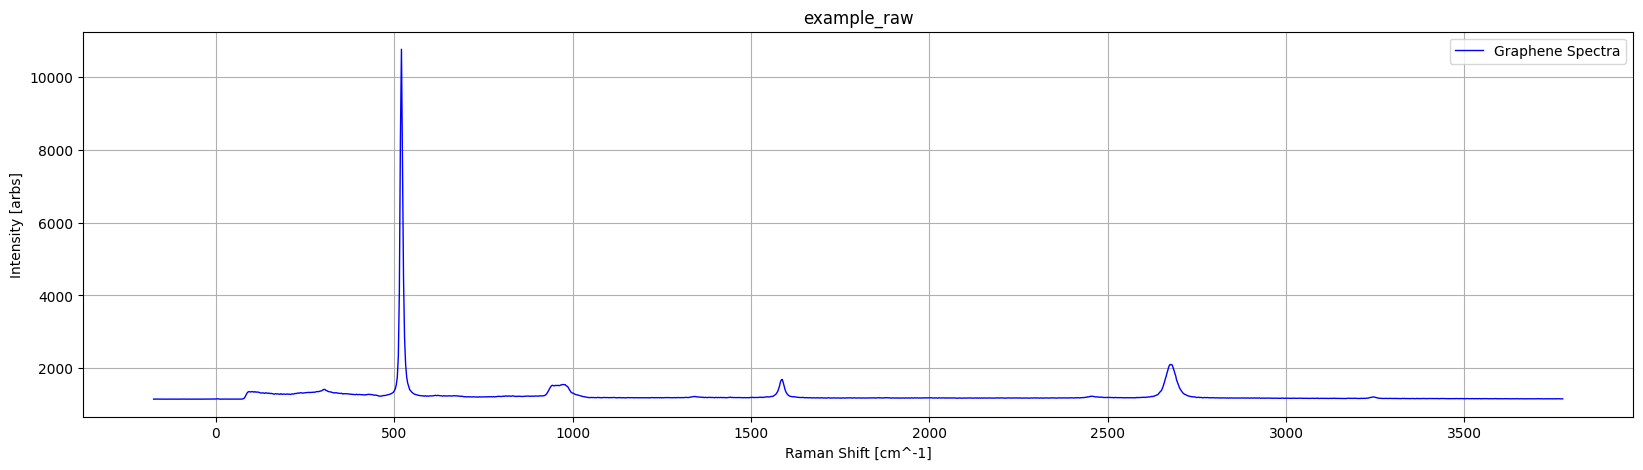

In [69]:
# Graphing
fig0 = plt.figure(figsize=(20,5))
ax = fig0.add_subplot(1,1,1)
ax.plot(df_raw,linewidth=1,label='Graphene Spectra',color='b')
ax.grid()
ax.set_ylabel('Intensity [arbs]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_raw')
ax.legend()
plt.show()

In [75]:
'''
NOISE CLEARING.
To perform proper analysis on the RAMAN spectrum, it is necessary to perform noise cleaning on the raw data.
This cleaning includes silicon spectrum subtraction, analysis range limits, normalization and signal smoothing.
'''
# Spectral Substraction of Silicon
reference_path = 'reference.txt'
df_reference =  pd.read_csv(reference_path, sep='\t', names=['shift','intensity'], index_col = 'shift')
df = df_raw - df_reference

# Shift Range Reduction
upper_bound = 3000
lower_bound = 1000
df = df.loc[lower_bound:upper_bound]

# Normalization
df = abs(df)/df.max()

# Save Clean Data
df.to_csv('example_noiseless.txt',sep='\t', index=True, header = False)

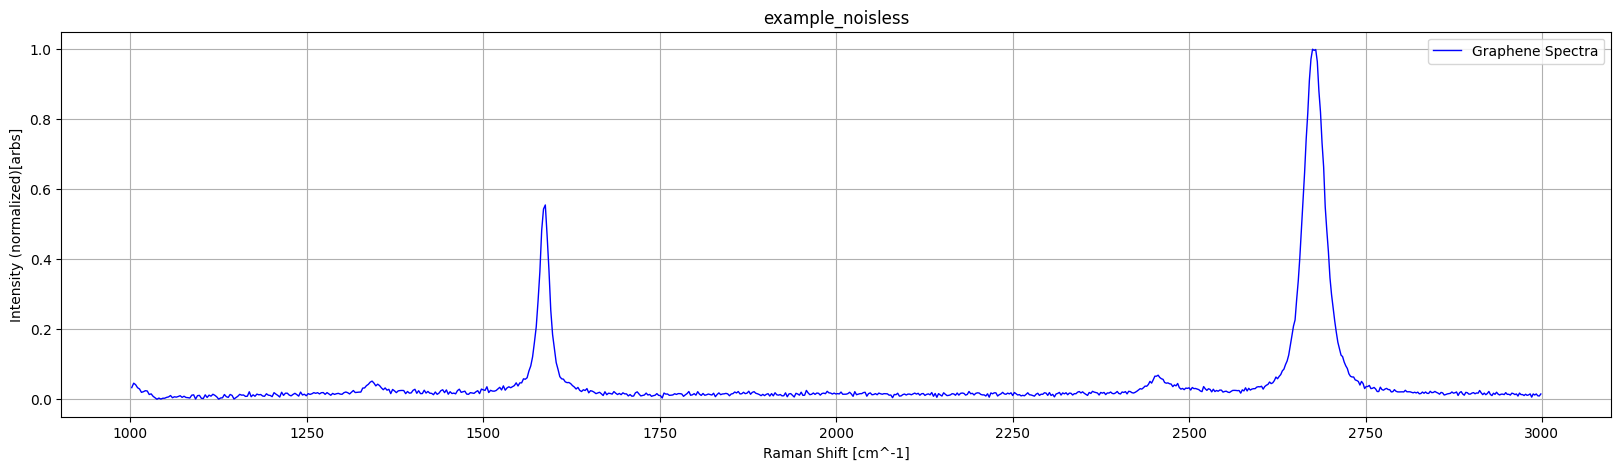

In [76]:
# Graphing
fig1 = plt.figure(figsize=(20,5))
ax = fig1.add_subplot(1,1,1)
ax.plot(df,linewidth=1,label='Graphene Spectra',color='b')
ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_noisless')
ax.legend()
plt.show()

In [87]:
'''
PEAK FINDING.
'''
# Peak Finding
height = 0.05
prominence = 0.1
distance = None 
p, _ = fp(x=df.intensity,height = height, prominence = prominence, distance = distance)
peaks = df.iloc[p]

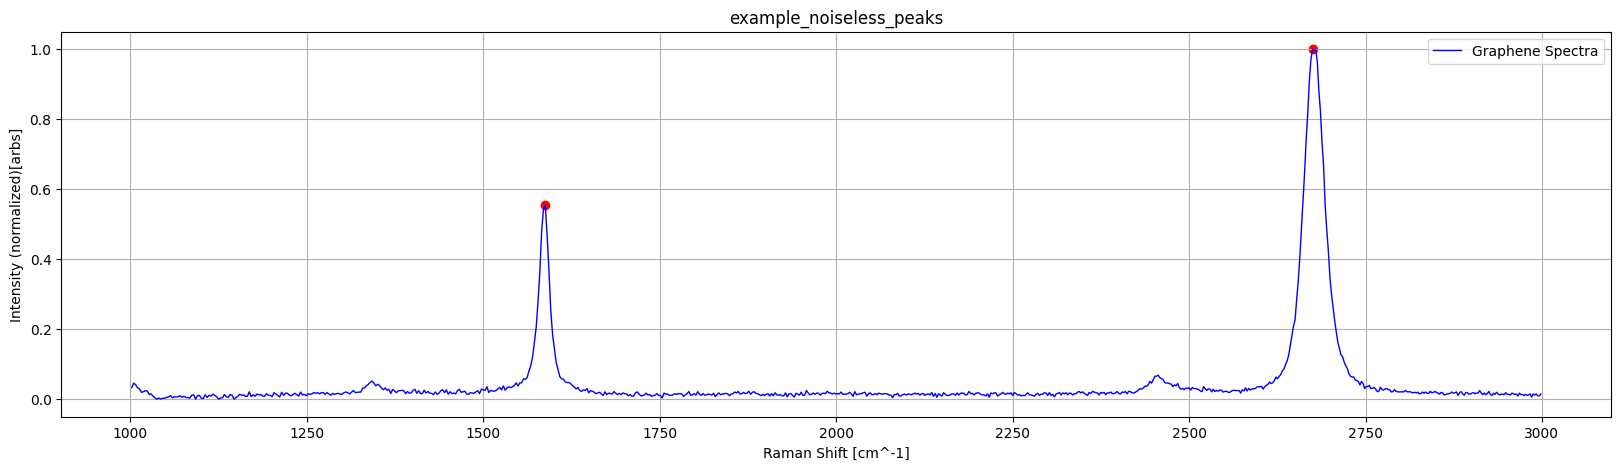

In [88]:
# Graphing
fig2 = plt.figure(figsize=(20,5))
ax = fig2.add_subplot(1,1,1)
ax.plot(df,linewidth=1,label='Graphene Spectra',color='b')
ax.scatter(peaks.index.values,peaks, color='r')
ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_noiseless_peaks')
ax.legend()
plt.show()

In [101]:
'''
LORENTZ FITTING.
n is the lorentz level, x is the variable, x0 is the array of peak position,
a and gam are the array of A and gamma which represent area and widht of peaks.
'''
def _1lorentz( x, a, gam, i ):
    return a * gam**2 / ( gam**2 + ( x - peaks.index.values[i] )**2)

def _2lorentz( x, a0, gam0, a1, gam1) :
    return a0 * gam0**2 / ( gam0**2 + ( x - peaks.index.values[0] )**2) + a1 * gam1**2 / ( gam1**2 + ( x - peaks.index.values[1] )**2)
    
xData, yData = np.loadtxt('example_noiseless.txt', unpack=True )
popt, pcov = curve_fit(_2lorentz,xData,yData)
print(popt)

[ 0.54534048  9.24082492  1.03967874 15.9732494 ]


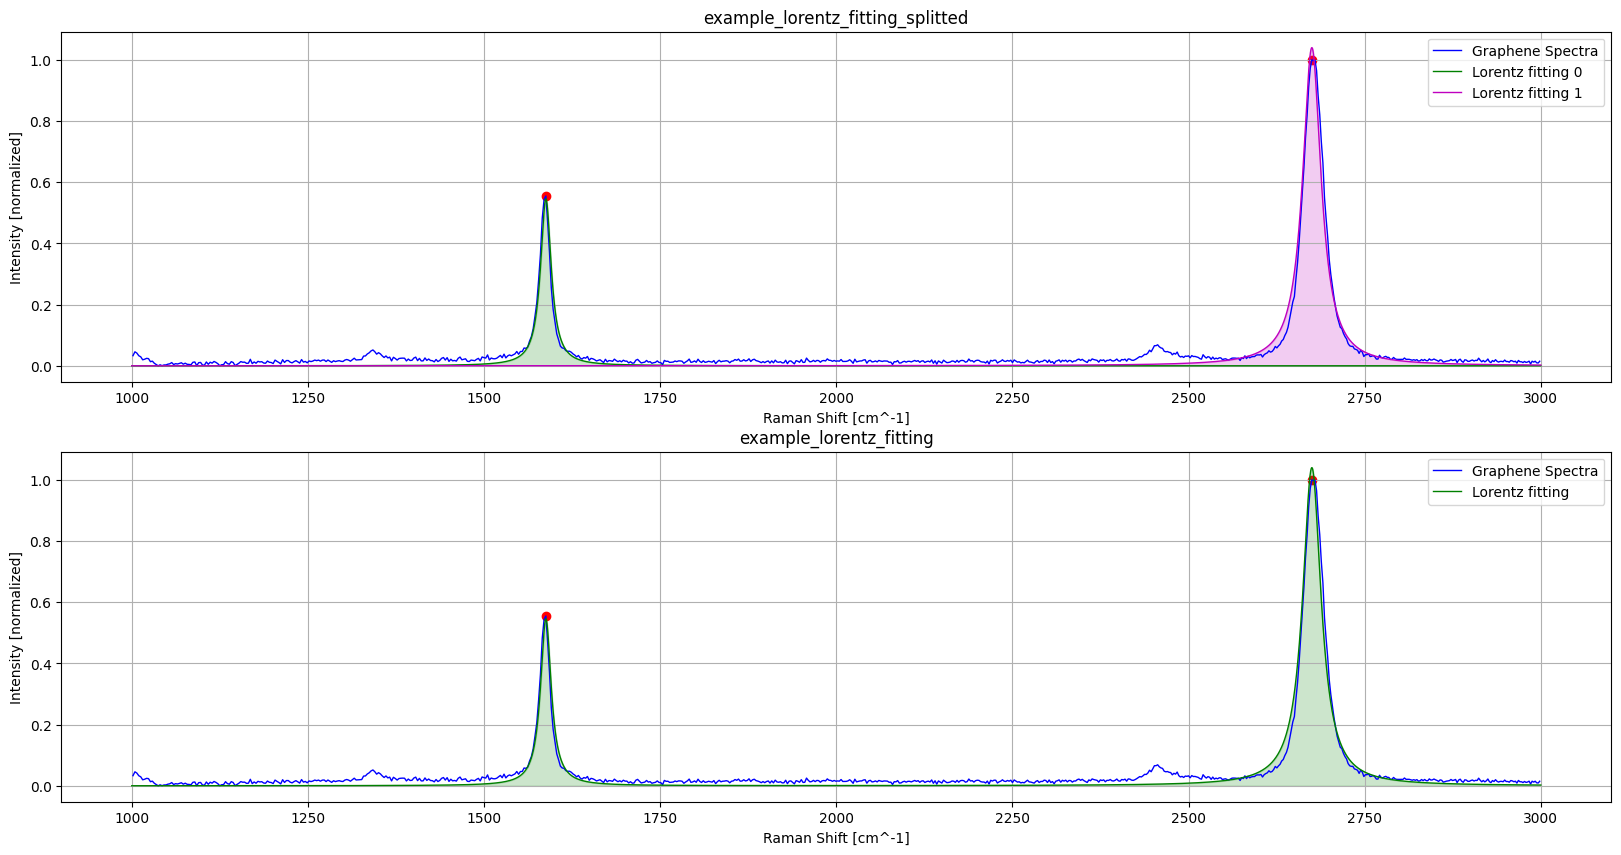

In [107]:
# Graphing
fig3 = plt.figure(figsize=(20,10))
ax = fig3.add_subplot(2,1,1)
bx = fig3.add_subplot(2,1,2)

ax.plot(df,linewidth=1,label='Graphene Spectra',color='b') # experimental data
ax.scatter(peaks.index.values,peaks, color='r') # peaks fitting

bx.plot(df,linewidth=1,label='Graphene Spectra',color='b') # experimental data
bx.scatter(peaks.index.values,peaks, color='r') # peaks fitting

# lorentz fitting
x = np.arange(1000, 3000, 0.01)

ax.plot(x,_1lorentz(x,popt[0],popt[1],0),linewidth=1,label='Lorentz fitting 0',color='g',alpha = 1.0) 
ax.fill_between(x, 0, _1lorentz(x,popt[0],popt[1],0), color='g', alpha=.2)

ax.plot(x,_1lorentz(x,popt[2],popt[3],1),linewidth=1,label='Lorentz fitting 1',color='m',alpha = 1.0) 
ax.fill_between(x, 0, _1lorentz(x,popt[2],popt[3],1), color='m', alpha=.2)

bx.plot(x,_2lorentz(x,popt[0],popt[1],popt[2],popt[3]),linewidth=1,label='Lorentz fitting',color='g',alpha = 1.0) 
bx.fill_between(x, 0,_2lorentz(x,popt[0],popt[1],popt[2],popt[3]), color='g', alpha=.2)

ax.grid()
ax.set_ylabel('Intensity [normalized]')
ax.set_xlabel('Raman Shift [cm^-1]')
ax.set_title(filename + '_lorentz_fitting_splitted')
ax.legend()

bx.grid()
bx.set_ylabel('Intensity [normalized]')
bx.set_xlabel('Raman Shift [cm^-1]')
bx.set_title(filename + '_lorentz_fitting')
bx.legend()
plt.show()